In [74]:
# base imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
sample_submission_df = pd.read_csv('./sample_submission.csv')
test_df = pd.read_csv('./test.csv', index_col=0)
train_df = pd.read_csv('./train.csv', index_col=0)

y = train_df.drop(columns=['trip_duration'])
sample_df = train_df.sample(int(len(train_df) * 0.05))

train_df.shape, sample_df.shape

((1458644, 10), (72932, 10))

In [76]:
## Let's examine the training dataset

sample_df.columns
sample_df.dtypes

vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

## Problem Statement

Provided with this data, we must predict the duration that each trip will have given the test data, we will try to make a model predict the time as close as possible, let's see if we can do it! This is working with time-series data, so it might be a little bit tricky. Let's see if we can figure it out.

In [77]:
## 1) Data Head 10 Lines

sample_df.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2509314,1,2016-06-01 18:45:44,2016-06-01 18:56:50,1,-73.975578,40.754871,-73.988930,40.742573,N,666
id2962345,2,2016-06-17 16:16:46,2016-06-17 16:30:01,1,-73.997787,40.746109,-73.993729,40.754768,N,795
id3477960,2,2016-04-29 15:36:15,2016-04-29 15:57:37,1,-74.002174,40.729504,-73.974876,40.763706,N,1282
id3323959,2,2016-03-11 17:14:20,2016-03-11 17:17:57,3,-73.955109,40.773144,-73.952309,40.782333,N,217
id2488294,2,2016-02-04 08:20:11,2016-02-04 08:29:26,5,-73.969231,40.760792,-73.986168,40.751629,N,555
id0508225,1,2016-02-23 06:27:23,2016-02-23 06:31:41,1,-73.991447,40.749882,-73.984131,40.755051,N,258
id1211660,2,2016-05-26 11:46:02,2016-05-26 11:49:36,1,-73.965622,40.762688,-73.967583,40.768829,N,214
id0125936,2,2016-05-05 20:19:44,2016-05-05 20:32:16,1,-73.995522,40.759418,-74.007568,40.740898,N,752
id3205326,1,2016-06-25 13:00:30,2016-06-25 13:06:44,1,-73.971405,40.766270,-73.980408,40.767422,N,374


In [78]:
## 2) Data Information

sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72932 entries, id2509314 to id2492315
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vendor_id           72932 non-null  int64  
 1   pickup_datetime     72932 non-null  object 
 2   dropoff_datetime    72932 non-null  object 
 3   passenger_count     72932 non-null  int64  
 4   pickup_longitude    72932 non-null  float64
 5   pickup_latitude     72932 non-null  float64
 6   dropoff_longitude   72932 non-null  float64
 7   dropoff_latitude    72932 non-null  float64
 8   store_and_fwd_flag  72932 non-null  object 
 9   trip_duration       72932 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 6.1+ MB


In [79]:
## 3) Data Description

sample_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,72932.000000,72932.000000,72932.000000,72932.000000,72932.000000,72932.000000,72932.000000
mean,1.538269,1.661630,-73.972985,40.750960,-73.972962,40.751818,972.254333
std,0.498537,1.317342,0.066391,0.033275,0.065607,0.035380,3453.752037
min,1.000000,0.000000,-75.455917,37.851051,-79.338699,37.851051,1.000000
25%,1.000000,1.000000,-73.991823,40.737339,-73.991318,40.736023,396.000000
50%,2.000000,1.000000,-73.981705,40.754242,-73.979813,40.754440,659.000000
75%,2.000000,2.000000,-73.967247,40.768311,-73.962944,40.769852,1069.000000
max,2.000000,7.000000,-61.335529,44.371944,-61.335529,43.147583,86369.000000


([<matplotlib.patches.Wedge at 0x2248defb370>,
 [Text(0.13192821940358482, 1.0920599548216205, '1'),
  Text(-0.13192832164961665, -1.0920599424696043, '2')],
 [Text(0.07196084694740988, 0.5956690662663384, '46.2%'),
  Text(-0.0719609027179727, -0.5956690595288751, '53.8%')])

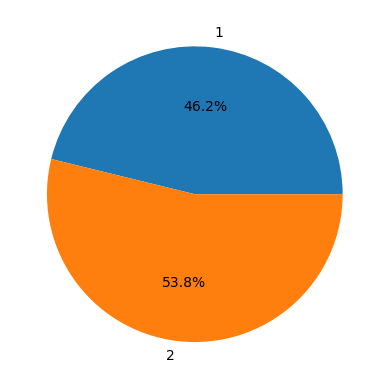

In [80]:
## 4) Percent of each vendor of data

vendors = sample_df['vendor_id']

labels = list(vendors.unique())

uniq_vendors = list(vendors.unique())
vendors_count = {}
labels = [str(x) for x in uniq_vendors]
for each_unique_vendor in uniq_vendors:
    vendors_count[each_unique_vendor] = len(sample_df[sample_df['vendor_id'] == each_unique_vendor])

values = list([vendors_count[x] for x in uniq_vendors])
plt.pie(values, labels=labels, autopct='%1.1f%%')

#### So, according to this graph, we can see that the vendors are roughly split between who is taking the passengers, this is with a sample dataset, so let's see with the real deal.

In [81]:
from math import acos, sin, cos

# computes the total distance traveled between the two points, now since we have their distance in km, we can calculate the km/h using the total time
sample_df['total_distance'] = np.arccos(np.sin(sample_df['pickup_latitude']) * np.sin(sample_df['dropoff_latitude']) + np.cos(sample_df['pickup_latitude']) * np.cos(sample_df['dropoff_latitude']) * np.cos(sample_df['dropoff_longitude'] - sample_df['pickup_longitude'])) * 6371
sample_df['speed'] = sample_df['total_distance'] / (sample_df['trip_duration'] / 3600)
sample_df['pickup_datetime'] = pd.to_datetime(sample_df['pickup_datetime'])
sample_df['dropoff_datetime'] = pd.to_datetime(sample_df['dropoff_datetime'])
sample_df['pickup_day'] = sample_df['pickup_datetime'].map(lambda x: x.day)
sample_df['pickup_month'] = sample_df['pickup_datetime'].map(lambda x: x.month)
sample_df['pickup_year'] = sample_df['pickup_datetime'].map(lambda x: x.year)
sample_df['dropoff_day'] = sample_df['dropoff_datetime'].map(lambda x: x.day)
sample_df['dropoff_month'] = sample_df['dropoff_datetime'].map(lambda x: x.month)
sample_df['dropoff_year'] = sample_df['dropoff_datetime'].map(lambda x: x.year)
sample_df = sample_df.drop(columns=['pickup_datetime', 'dropoff_datetime'])
sample_df = pd.get_dummies(sample_df, columns=['store_and_fwd_flag'])

sample_df.describe(), sample_df.dtypes

c:\Users\flyin\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


(          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
 count  72932.000000     72932.000000      72932.000000     72932.000000   
 mean       1.538269         1.661630        -73.972985        40.750960   
 std        0.498537         1.317342          0.066391         0.033275   
 min        1.000000         0.000000        -75.455917        37.851051   
 25%        1.000000         1.000000        -73.991823        40.737339   
 50%        2.000000         1.000000        -73.981705        40.754242   
 75%        2.000000         2.000000        -73.967247        40.768311   
 max        2.000000         7.000000        -61.335529        44.371944   
 
        dropoff_longitude  dropoff_latitude  trip_duration  total_distance  \
 count       72932.000000      72932.000000   72932.000000    72917.000000   
 mean          -73.972962         40.751818     972.254333      225.710107   
 std             0.065607          0.035380    3453.752037      279.431572   
 m

In [85]:
from sklearn.feature_selection import mutual_info_regression

nan_columns = []
for each_column in sample_df.columns:
    if sample_df[each_column].hasnans:
        nan_columns.append(each_column)

# data = mutual_info_regression(sample_df.drop(columns=['trip_duration']), sample_df['trip_duration'])
nan_columns ## Imputation!

['total_distance', 'speed']